## this notebook is for our "hack" of ExoTransmit

**We're producing transit spectra for 2 different systems: Trappist-1 b around the Sun, and an "M-dwarf" transiting the same Sun. We then multiply out the stellar radius in the transit spectra for each, so we can then divide the planet spectra by the M-dwarf spectra.**

Notes: all the spectra with ExoTransmit are calculated on the exact same wavelength grid of $0.3 - 30 \mu \text{m}$, so I use the same wavelength variable throughout. Also, ExoTransmit outputs in percent, but I've converted to ppm where needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from smoothing import adap_smooth # my function

In [2]:
# Can be found in kipping/Exo_Transmit/Spectra
# as of 19 Jan 2024
spectra_path = '/Users/coffey/Downloads/kipping/Exo_Transmit/Spectra'

### M dwarf: TRAPPIST-1
**T-P profile**                : 2500 K  
**EOS**                        : 1X_solar_gas  
**Planet g (m/s^2)**           : 1736  
**Planet R (m)**               : 8.2927e+7  
**Star R (m)**                 : 6.957e+8  
**Pressure of cloud top (Pa)** : 0.0  
**Rayleigh scattering factor** : 0.0

**Chemistry** : VO, TiO, H2O, Na, K, no collision induced, no scattering  

These parameters were obtained from Genaro's email, [Agol et al. 2021](https://iopscience.iop.org/article/10.3847/PSJ/abd022/pdf), and [Acuña et al. 2021](https://www.aanda.org/articles/aa/pdf/2021/03/aa39885-20.pdf).

In [3]:
t1_spectrum = np.loadtxt(f'{spectra_path}/transmission_trappist1.dat', skiprows = 2).T #full 0.3 - 30 um
wave    = t1_spectrum[0][:2900] * 1e6 # microns
t1_spec = t1_spectrum[1][:2900] / 100 # convert from %

### Trappist-1 b
**T-P profile**                : 400 K  
**EOS**                        : 1X_solar_gas  
**Planet g (m/s^2)**           : 10.8096  
**Planet R (m)**               : 7.118e+6  
**Star R (m)**                 : 6.957e+8  
**Pressure of cloud top (Pa)** : 0.0  
**Rayleigh scattering factor** : 0.0

**Chemistry** : VO, TiO, H2O, Na, K, no collision induced, no scattering  

In [4]:
# using ExoTransmit
t1b_spectrum = np.loadtxt(f'{spectra_path}/transmission_trappist1b.dat', skiprows = 2).T
t1b_spec     = t1b_spectrum[1][:2900] / 100 # convert from %

In [5]:
# flat spectrum = no atmosphere
Rs   = 6.957e8  # Sun
Rt1b = 7.118e6  # Trappist-1 b
Rt1  = 8.2927e7 # Trappist-1

t1b_depth     = (Rt1b / Rs)**2
flat_t1b_spec = np.repeat(t1b_depth, len(t1_spec))

In [6]:
# for comparison, T1b around T1 w/ ExoTransmit
t1b_og_spectrum  = np.loadtxt(f'{spectra_path}/transmission_t1b_around_t1_noaerosols.dat', skiprows = 2).T
t1b_og_spec      = t1b_og_spectrum[1][:2900] * 1e4

In [7]:
# for plotting (dotted line)
t1bt1_fixed_depth = (Rt1b/Rt1)**2 * 1e6 # fixed transit depth of T1b around T1

### Hacking time

In [8]:
# Multiplying out the Sun's radius
t1b_spec_noRs      = np.sqrt(t1b_spec) * Rs
t1_spec_noRs       = np.sqrt(t1_spec) * Rs
flat_t1b_spec_noRs = np.sqrt(flat_t1b_spec) * Rs

In [9]:
# combining the spectra for our new (Rp/Rs)^2
hacked_spec      = (t1b_spec_noRs / t1_spec_noRs)**2 * 1e6      # ppm
flat_hacked_spec = (flat_t1b_spec_noRs / t1_spec_noRs)**2 * 1e6 # ppm

In [10]:
# smoothing to JWST resolution (R ~ 100 for prism)
smooth_hacked_spec = adap_smooth(wave, hacked_spec, R = 100)
smooth_flat_hacked_spec = adap_smooth(wave, flat_hacked_spec, R = 100)

smooth_t1b_spec = adap_smooth(wave, t1b_spec, R = 100)
smooth_t1_spec = adap_smooth(wave, t1_spec, R = 100)
smooth_og_spec = adap_smooth(wave, t1b_og_spec, R = 100)


Text(0.5, 0, 'Wavelength (microns)')

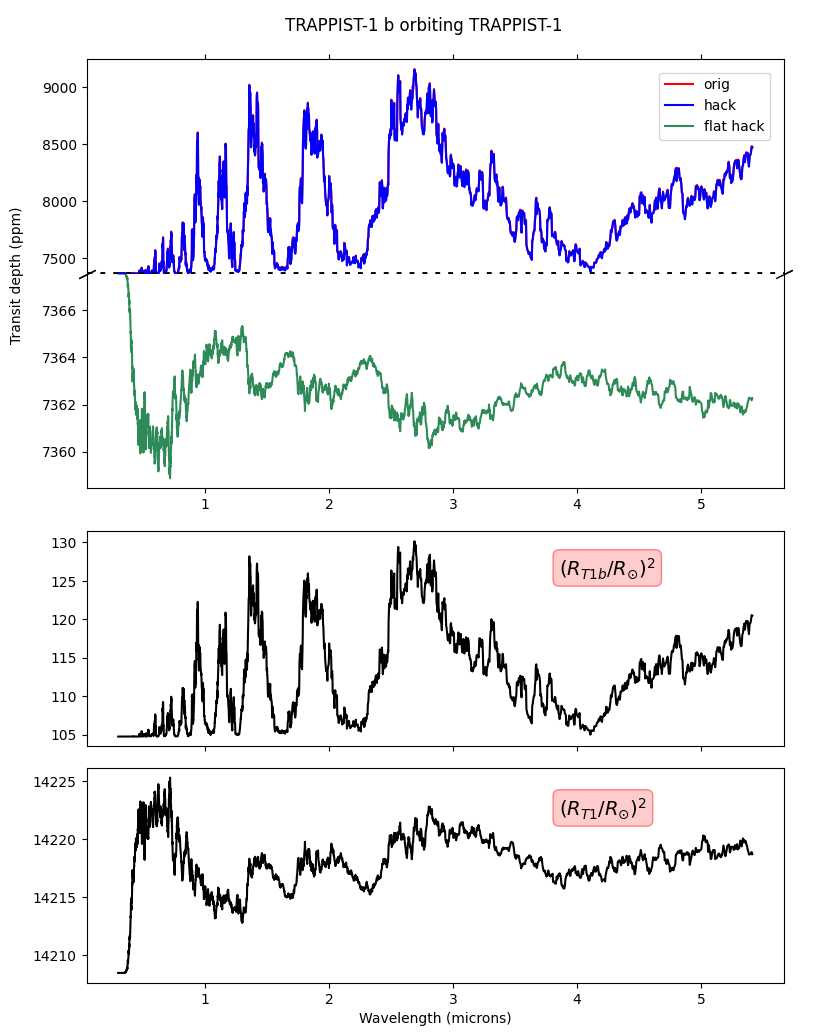

In [11]:
# added a couple invisible axis elements to give space b/w last two plots while 
# closing the space between the first two
fig, axs = plt.subplots(6, 1, figsize = (9,12), height_ratios = [1,1,0.2,1,0.1,1], sharex = True)
fig.subplots_adjust(hspace = 0)

# Spectra
axs[0].plot(wave, smooth_og_spec, c = 'red')
axs[0].plot(wave, smooth_hacked_spec, c = 'blue')
axs[1].plot(wave, smooth_flat_hacked_spec, c = 'seagreen')
axs[3].plot(wave, np.array(smooth_t1b_spec) * 1e6, c = 'black')
axs[5].plot(wave, np.array(smooth_t1_spec) * 1e6, c = 'black')
fig.legend(['orig', 'hack', 'flat hack'], loc = (0.805,0.865))

# Broken axis
axs[0].set_ylim(t1bt1_fixed_depth, None)
axs[1].set_ylim(None, t1bt1_fixed_depth)
axs[0].spines.bottom.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[0].xaxis.tick_top()
axs[1].tick_params(labeltop=True)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()
axs[1].xaxis.grid(True, which='minor')
axs[2].set_visible(False)
axs[4].set_visible(False)

# Slanted lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], ms=12,ls="none", c='k', mec='k', mew=1, clip_on=False)
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)

# Plotting fixed transit depth to compare
axs[0].axhline(y = t1bt1_fixed_depth, c = 'black', ls = 'dotted', lw = 3.5)

# Labels
fig.suptitle('TRAPPIST-1 b orbiting TRAPPIST-1', y = 0.915)
fig.text(0.04, 0.7, 'Transit depth (ppm)', va='center', rotation='vertical')
fig.text(0.65, 0.45, r'$(R_{T1b}/R_{\odot})^2$', fontsize = 14, bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
fig.text(0.65, 0.25, r'$(R_{T1}/R_{\odot})^2$', fontsize = 14, bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
axs[5].set_xlabel('Wavelength (microns)')

## For pandexo, let's smooth the spectrum to the smallest resolution possible while still capturing the main features

In [12]:
supersmooth_hacked_spec = adap_smooth(wave, hacked_spec, R = 10)
supersmooth_flat_hacked_spec = adap_smooth(wave, flat_hacked_spec, R = 10)

Text(0.5, 0, 'Wavelength (microns)')

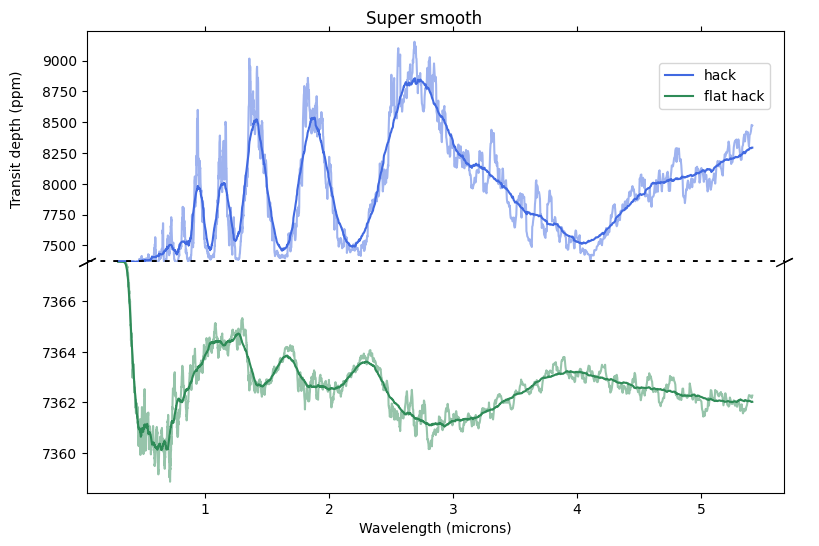

In [13]:
# added a couple invisible axis elements to give space b/w last two plots while 
# closing the space between the first two
fig, axs = plt.subplots(2, 1, figsize = (9,6), height_ratios = [1,1], sharex = True)
fig.subplots_adjust(hspace = 0)

# Spectra
axs[0].plot(wave, smooth_hacked_spec, c = 'royalblue', alpha = 0.5, label = '_nolegend_')
axs[1].plot(wave, smooth_flat_hacked_spec, c = 'seagreen', alpha = 0.5, label = '_nolegend_')
axs[0].plot(wave, supersmooth_hacked_spec, c = 'royalblue')
axs[1].plot(wave, supersmooth_flat_hacked_spec, c = 'seagreen')
fig.legend(['hack','flat hack'], loc = (0.805,0.8))

# Broken axis
axs[0].set_ylim(t1bt1_fixed_depth, None)
axs[1].set_ylim(None, t1bt1_fixed_depth)
axs[0].spines.bottom.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[0].xaxis.tick_top()
axs[1].tick_params(labeltop=True)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()
axs[1].xaxis.grid(True, which='minor')

# Slanted lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], ms=12,ls="none", c='k', mec='k', mew=1, clip_on=False)
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)

# Plotting fixed transit depth to compare
axs[0].axhline(y = t1bt1_fixed_depth, c = 'black', ls = 'dotted', lw = 3.5)

# Labels
fig.suptitle('Super smooth', y = 0.915)
fig.text(0.04, 0.7, 'Transit depth (ppm)', va='center', rotation='vertical')
axs[1].set_xlabel('Wavelength (microns)')

## Write it to a text file

**Pandexo wants $(R_{p}/R_{s})^2$ in decimal units (NOT PPM). I'll give Pandexo the unsmoothed spectrum and will bin after, per their recommendation.**

In [14]:
# Saving the array in a text file
pandexo_hacked_spec = np.array(hacked_spec) / 1e6
pandexo_flat_hacked_spec = np.array(flat_hacked_spec) / 1e6

trappist_hacked_spectrum = np.column_stack((wave, pandexo_hacked_spec))
np.savetxt("./pandexo_input_spectra/trappist_hacked_spectrum.txt", trappist_hacked_spectrum)

flat_trappist_hacked_spectrum = np.column_stack((wave, pandexo_flat_hacked_spec))
np.savetxt("./pandexo_input_spectra/flat_trappist_hacked_spectrum.txt", flat_trappist_hacked_spectrum)

## Adding on the pandexo errors
**The files are in the format x,y,err and the y and errors are already in ppm**

In [15]:
pandexo_errs = np.loadtxt('./pandexo_output/pandexo_errs.txt').T

Text(0.5, 0, 'Wavelength (microns)')

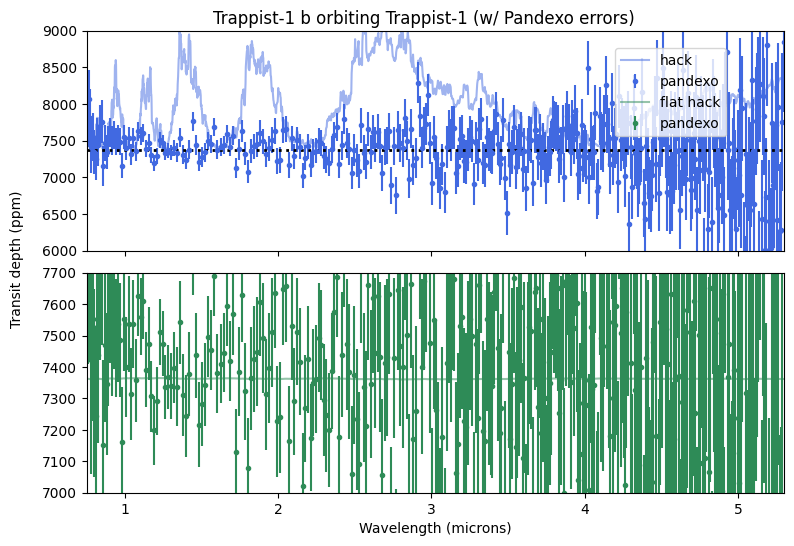

In [28]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)
axs[1].set_xlim(0.75, 5.3)
axs[0].set_ylim(6000,9000)
axs[1].set_ylim(7000,7700)

# Spectra
axs[0].plot(wave, smooth_hacked_spec, c = 'royalblue', alpha = 0.5)
axs[1].plot(wave, smooth_flat_hacked_spec, c = 'seagreen', alpha = 0.5)
axs[0].errorbar(pandexo_errs[0], pandexo_errs[1], pandexo_errs[2], fmt = '.', c = 'royalblue')
axs[1].errorbar(pandexo_errs[0], pandexo_errs[1], pandexo_errs[2], fmt = '.', c = 'seagreen')


# Plotting fixed transit depth to compare
axs[0].axhline(y = t1bt1_fixed_depth, c = 'black', ls = 'dotted', lw = 2, label = '_nolegend_')

# Labels
fig.legend(['hack','pandexo', 'flat hack', 'pandexo'], loc = (0.775,0.75))
fig.suptitle('Trappist-1 b orbiting Trappist-1 (w/ Pandexo errors)', y = 0.915)
fig.text(0.04, 0.5, 'Transit depth (ppm)', va='center', rotation='vertical')
axs[1].set_xlabel('Wavelength (microns)')

In [17]:
print(f'Median error for pandexo w/ hacked spectrum: {np.median(pandexo_errs[2]):.3f} ppm')

Median error for pandexo w/ hacked spectrum: 326.632 ppm
